# Automatic Optimal N-Shot learning for Brain Tumor Detection. (Using Few Shot Learning)
**Description:**

A Brain tumor is considered as one of the aggressive diseases, among children and adults. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties. 

Despite deep convolutional neural networks achieved impressive progress in medical image computing and analysis, its paradigm of supervised learning demands a large number of training images and complex hyperparameter optimization processes. In clinical practices, collection of huge number of MRIs is difficult to acquire. We developed a deep learning pipeline with few-shot learning with automatic hyperparameter optimization for brain tumor detection.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install tensorflow

In [ ]:
# !pip install --upgrade tensorflow-hub

In [ ]:
# !pip install pyDOE

In [ ]:
# !pip install tabulate

In [ ]:
# !pip install tqdm

In [ ]:
# Importing required Libraries:
import os
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs

In [ ]:
# Creating a Class to load a dataset:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size = (img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(X, y, 
                                                                                                   one_hot_y, 
                                                                                                   test_size = test_size, 
                                                                                                   random_state = seed, 
                                                                                                   stratify = y)     

In [ ]:
# Creating an Object to load the dataset:
data = Dataset("/content/drive/MyDrive/Colab Notebooks/FSL/BT_Data_250", test_size=0.2, img_size=256)
print(data.X.shape, data.y.shape)

(200, 256, 256, 3) (200, 2)


**This module implements the R101x1 architecture, trained to perform multi-label classification on ImageNet-21k, a dataset with 14 milion images labeled with 21,843 classes. Its outputs are the 2048-dimensional feature vectors, before the multi-label classification head. This model can be used as a feature extractor or for fine-tuning on a new target task.**

In [ ]:
# Using Pretrained Image Embeddings:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)

(200, 2048) (51, 2048)


In [27]:
# Function for Model Building:
def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float) -> tf.keras.Model:
    model = tf.keras.Sequential()
    
    # One fully connected hidden layer
    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))
    
    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model

In [ ]:
# Function for Evaluating the Model:
def evaluate_model(
    nclasses, X, y, X_dev, y_dev, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our learning rate by a factor of 10 every 30% of the optimizer's total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(optimizer = Adam(learning_rate = ExponentialDecay(
                                                                    learning_rate,
                                                                    decay_steps = third_of_total_steps,
                                                                    decay_rate = 0.1,
                                                                    staircase = True
                                                                    )
                                   ),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"]
                 )
    
    # Train the model on the training set and evaluate it on the dev set.
    model.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = 0)
    
    _, train_acc = model.evaluate(X, y, batch_size = batch_size, verbose = 0)
    _, dev_acc = model.evaluate(X_dev, y_dev, batch_size = batch_size, verbose = 0)
    
    return model, train_acc, dev_acc

In [ ]:
# Cross-Validating the evaluated model:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params) -> dict:

    # Performs `nfolds` cross-validated training and evaluation of a model hyperparameter configuration,
    # Returns a dictionary of statistics about the outcome of the cross-validated experiment.
    
    _, nclasses = y.shape
    train_accs, dev_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, dev_index in tqdm(
        RepeatedStratifiedKFold(
                                n_splits = nfolds, 
                                n_repeats = nrepeats, 
                                random_state = seed).split(X, labels),
        total = nfolds*nrepeats, disable = not verbose):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_dev_fold = tf.gather(X, dev_index)
        y_dev_fold = tf.gather(y, dev_index)
        
        # Train and evaluate the model.
        _, train_acc, dev_acc = evaluate_model(
                                               nclasses,
                                               X_train_fold,
                                               y_train_fold,
                                               X_dev_fold,
                                               y_dev_fold,
                                               epochs = epochs,
                                               batch_size = batch_size,
                                               learning_rate = learning_rate,
                                               model_maker = model_maker,
                                               **model_params
                                               )
        
        train_accs.append(train_acc)
        dev_accs.append(dev_acc)
    
    # Aggregate.
    results = {
               "train_mean": np.mean(train_accs),
               "train_std": np.std(train_accs),
               "dev_mean": np.mean(dev_accs),
               "dev_std": np.std(dev_accs)
              }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Dev", results["dev_mean"], results["dev_std"]]
                ],
                headers = ["Set", "Mean", "Std. Dev."]))
    
    return results

In [ ]:
# We'll refer to these values throughout the notebook.
default_cv_evaluate_params = {
                              "X": X_embedding,
                              "y": data.y,
                              "labels": data.labels,
                              "nfolds": 5,
                              "nrepeats": 3,
                              "model_maker": make_model,
                              "epochs": 100,
                              "batch_size": 5,
                              "verbose": False,
                              "learning_rate": 3e-3,
                              "dropout_rate": 0.3,
                              "nhiddenunits": 64,
                              "l2_regularization": 1e-6
                              }

_ = cv_evaluate_model(**{**default_cv_evaluate_params, "verbose": True})

100%|██████████| 15/15 [02:30<00:00, 10.02s/it]

Set        Mean    Std. Dev.
-----  --------  -----------
Train  0.97        0.0941298
Dev    0.876667    0.0808634


In [ ]:
# Selecting the number of samples for Few Shot Learning:
nsamples = 10

In [ ]:
# `lhs` will yield a `nsamples`x2 matrix, with all values following the uniform distribution in [0,1]
np.random.seed()
x = lhs(n=2, samples=nsamples)

In [ ]:
# Scale dropout samples to be in [0,0.6]
dropout_rates = (x[:, 0]*.6)

In [ ]:
# Scale l2 samples to be in [-8, -1]
l2_rates = (x[:, 1]*-7 - 1)

In [ ]:
# Now scale l2 samples to follow the log scale in the range [10**-8,10**-1]
l2_rates = 10**l2_rates

In [ ]:
# cross validating our model on each hyperparameter sample, storing the dev set performance statistics for each run:
dev_means = np.zeros((nsamples, 1))
dev_stds = np.zeros((nsamples, 1))

for i in tqdm(range(nsamples)):
    results = cv_evaluate_model(**{**default_cv_evaluate_params,
                                   "dropout_rate": dropout_rates[i],
                                   "l2_regularization": l2_rates[i]}
                               )
    
    dev_means[i] = results["dev_mean"]
    dev_stds[i] = results["dev_std"]

100%|██████████| 10/10 [53:09<00:00, 318.94s/it]


Best l2_rate:	3.460593400955007e-06
Best dropout:	0.14368555262850552


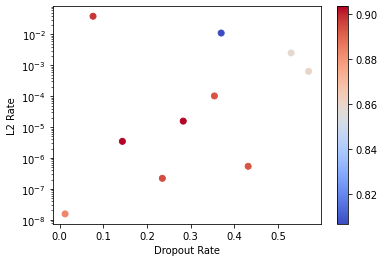

In [ ]:
# Visualizing the results over the hyperparameter space:
best_i = np.argmax(dev_means)
best_l2 = l2_rates[best_i]
print(f"Best l2_rate:\t{best_l2}")

best_dropout = dropout_rates[best_i]
print(f"Best dropout:\t{best_dropout}")

plt.scatter(dropout_rates, l2_rates, c=dev_means, cmap=plt.cm.coolwarm)
plt.xlabel("Dropout Rate")
plt.ylabel("L2 Rate")
plt.yscale("log")
plt.colorbar()
plt.show()

In [28]:
# Finding the Best DropOut and Best l2_regularization:
default_cv_evaluate_params["dropout_rate"] = best_dropout
default_cv_evaluate_params["l2_regularization"] = best_l2

In [29]:
# Searching for the best Hyperparameter: 
def search_hyperparam(
    param_name: str, lower: int, upper: int, nsamples: int,
    scale: str = "float", **cv_evaluate_params) -> float:
    
    """
    Cross validates a model along an evenly spaced range of `nsamples`values for a single hyperparameter (identified by `param_name`.
    The values are evenly spaced in the range `[lower,upper]`, and scaled according to `scale`.
    """
    
    # Sample the hyperparameter values to try.
    param_values = np.linspace(lower, upper, nsamples)
    
    if scale == "log":
        param_values = 10**param_values
    elif scale == "int":
        param_values = param_values.astype(int)
    
    # Evaluate the model at each of the values.
    dev_means = np.zeros((nsamples, 1))
    dev_stds = np.zeros((nsamples, 1))
    
    for i in tqdm(range(nsamples)):
        results = cv_evaluate_model(**{**cv_evaluate_params, param_name: param_values[i]})
        dev_means[i] = results["dev_mean"]
        dev_stds[i] = results["dev_std"]
    
    # Find the best value.
    best_param_value = param_values[np.argmax(dev_means)]
    print(f"Best {param_name} value: {best_param_value}")
    
    # Plot scores achieved for all values.
    plt.plot(param_values, dev_means)
    plt.xlabel(param_name)
    plt.ylabel("Mean Dev Set Accuracy")
    
    if scale == "log":
        plt.xscale("log")
        
    plt.show()
    
    return best_param_value

100%|██████████| 10/10 [1:13:43<00:00, 442.32s/it]

Best epochs value: 250


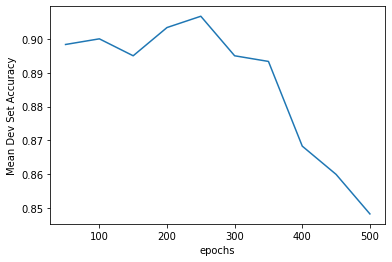

In [30]:
# Searching over the number of epochs in the steps of 50 in range [50,500]:
best_epochs = search_hyperparam("epochs", 50, 500, 10, scale="int", **default_cv_evaluate_params)

In [37]:
# Searching over the number of epochs in the steps of 40 in range [400,800] 
# best_epochs2 = search_hyperparam("epochs", 400, 800, 10, scale="int", **default_cv_evaluate_params)

In [32]:
# Finalozing on the best Epochs:
default_cv_evaluate_params["epochs"] = best_epochs

In [33]:
# Training the final model using our best found configuration and evaluate it on our independent test sample.
def evaluate_final(params: dict) -> float:
    
    steps_per_epoch = math.ceil(len(X_embedding) / params["batch_size"])
    third_of_total_steps = math.floor(params["epochs"] * steps_per_epoch / 3)

    # Make and compile the model.
    model = make_model(
                       data.nclasses,
                       dropout_rate = params["dropout_rate"],
                       nhiddenunits = params["nhiddenunits"],
                       l2_regularization = params["l2_regularization"]
                       )
    
    model.compile(optimizer = Adam(learning_rate = ExponentialDecay(
                                                                    params["learning_rate"],
                                                                    decay_steps = third_of_total_steps,
                                                                    decay_rate = 0.1,
                                                                    staircase = True
                                                                    )
                                  ),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"]
                 )

    # Train the model on the full training set (no development set)
    model.fit(
              X_embedding,
              tf.convert_to_tensor(data.y),
              batch_size = params["batch_size"],
              epochs = params["epochs"],
              verbose = 0
              )

    # Evaluate the fitted model on the test set.
    _, test_acc = model.evaluate(
                                 X_test_embedding,
                                 data.y_test, 
                                 verbose = 0
                                 )
    
    return test_acc

In [34]:
# Got good test set accuracy, but we can train this model multiple times (always on the same training data) and evaluating it on the test set each time.
test_acc = evaluate_final(default_cv_evaluate_params)
print(f"Final test set accuracy:\t{test_acc:.2f}")

Final test set accuracy:	0.90


In [35]:
# Evaluating on the test set each time:
test_accs = []
for _ in tqdm(range(30)):
    test_accs.append(evaluate_final(default_cv_evaluate_params))

  7%|▋         | 2/30 [00:47<11:01, 23.61s/it]

 10%|█         | 3/30 [01:29<14:21, 31.90s/it]

100%|██████████| 30/30 [16:30<00:00, 33.01s/it]


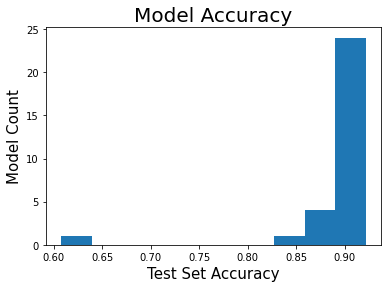

In [36]:
# Plotting The test accuracy by training this model multiple times:
plt.hist(test_accs)
plt.title('Model Accuracy', fontsize = 20)
plt.xlabel("Test Set Accuracy", fontsize = 15)
plt.ylabel("Model Count", fontsize = 15)
plt.show()